<h2><center>  Classification of Customer Reviews using Multinomial Naive-Bayes Classifier </center></h2> 

**This notebook shows the steps used in the implimentation of customer review classification model using the Naive Bayes Classifier. This work was done as a part of the Udacity Machine Learning Engineering nano-degree program; The Individual Capstone Project.**
- Data sets: Amazon reviews, Yelp reviews, IMDB reviews
- Labels: Good, Bad
- Data set size: 2748 reviews
- NLP libraries: NLTK, python3-string

**Data Set Link:**\
(Center for Machine Learning and Intelligent Systems, University of California, Irvine, CA.)\
https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

**GitHub:**\
(Project report and complete analysis code)\
https://github.com/nalinda05kl**

**E-mail:**\
nalinda05kl@gmail.com


### See the following bullet points for main steps:


- **Importing necessary libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# numerical 
import pandas as pd
import numpy as np
import itertools

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# language/string processing libraries
import string
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from collections import Counter
from termcolor import colored

# modeling tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix


- **A "combined-dataset" was created using reviews from three companies; Amazon, Yelp, IMDB. Pandas DataFrames was used to structure the data set**

In [3]:
filenames = ['./Data/amazon_cells_labelled.txt', './Data/imdb_labelled.txt', './Data/yelp_labelled.txt']
with open('./Data/combined_reviews.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

In [4]:
Combined_DF_raw = pd.read_csv("./Data/combined_reviews.txt", sep='\t', names = ["Review", "Label"])
Combined_DF_raw = Combined_DF_raw.sample(frac=1).reset_index(drop=True)
Combined_DF_raw.head(10)

,Review,Label
0,Battery life still not long enough in Motorola...,0
1,The kids are annoying.,0
2,Its not user friendly.,0
3,I wasn't really impressed with Strip Steak.,0
4,"It is light, easy to use, and has very clear r...",1
5,"A very good film indeed, about great and uncon...",1
6,My husband said she was very rude... did not e...,0
7,Would not recommend to others.,0
8,Don't do it!!!!,0
9,I have two more years left in this contract an...,0


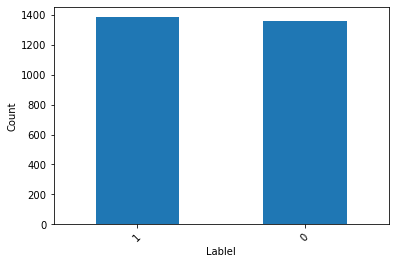

In [5]:
Combined_DF_raw["Label"].value_counts().plot(kind='bar', rot=45, xlabel="Lablel", ylabel="Count");

In [6]:
print("Shape of the dataset: ", Combined_DF_raw.shape)

Shape of the dataset:  (2748, 2)


- **Removal of data entries with empty strings.**

In [7]:
Combined_DF = Combined_DF_raw[Combined_DF_raw['Review'] != '']
Combined_DF.shape

(2748, 2)

- **Data set was splitted into trainig and testing data sets.**

In [8]:
Combined_Df_RW = Combined_DF.drop('Label', axis=1)
Combined_Df_LB = Combined_DF["Label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(Combined_Df_RW, 
                                                    Combined_Df_LB, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [10]:
print("Training reviews shape: ", X_train.shape)
print("Testing reviews shape: ", X_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

Training reviews shape:  (2198, 1)
Testing reviews shape:  (550, 1)
Training labels shape:  (2198,)
Testing labels shape:  (550,)


- **As the baseline model, a naive model which predicts all the reviews as good reviews (label=1) is selected. A model must perform at least better than the accuracy of the "naive-guessing" model so that it can be considered for further improvements.**

In [11]:
y_test_all_good = np.ones(len(X_test)).tolist()
print("Accuracy of the naive-guessing : ", np.round(np.mean(y_test_all_good == y_test)*100, 3), "%")

Accuracy of the naive-guessing :  48.364 %


In [12]:
print("The Classification Report:")
print(metrics.classification_report(y_test, y_test_all_good, target_names="NP"))

The Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       284
           P       0.48      1.00      0.65       266

    accuracy                           0.48       550
   macro avg       0.24      0.50      0.33       550
weighted avg       0.23      0.48      0.32       550



- **Cleaning text data. Decoding of any accents and removal of unnecessary characters**

In [2]:
def strip_accents(text):
    """
    Remove accents from input String.
    """
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def remove_nonalphanumerics(text):
    """
    Remove characters and spaces which are not alpha-neumeric.
    Empty brackets are replaced by _ and hypens are not removed
    """
    text = strip_accents(text.lower())
    text = re.sub('[ ]+', '_', text)
    text = re.sub('[^0-9a-zA-Z_-]', '', text)
    return text

In [3]:
test_string = "My comment: I found that, Kanò, Añolwa and Eva were 'best' friends for 20+ years.     Do you agree??"
re.sub('_', ' ', remove_nonalphanumerics(test_string))

'my comment i found that kano anolwa and eva were best friends for 20 years do you agree'

- **The occurrence of a certain word in the data set in important to understand the information in the reviews that could help the model in classification. I first look into the words-occurrence before doing the pre-processing**

In [15]:
def word_occurence(sent_list):
    '''
    returns the (word, frequency) tuple for a given list of sentences.
    '''
    Long_sent = ""
    for item in sent_list:
        Long_sent += item
        Long_sent += " "
    sent_list_split = Long_sent.split()
    most_occur = Counter(sent_list_split).most_common(25)
    return most_occur

In [16]:
word_occure_raw = word_occurence(X_train["Review"].tolist())

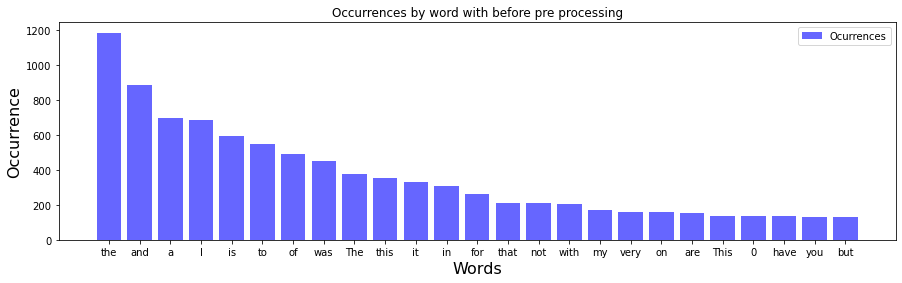

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
index = np.arange(len(word_occure_raw))
rects1 = plt.bar(x = np.arange(len(word_occure_raw)), 
                 height = [x[1] for x in word_occure_raw], 
                 width = 0.8, alpha=0.6, color='b',label='Ocurrences')

plt.xlabel('Words', size=16)
plt.ylabel('Occurrence', size=16)
plt.title('Occurrences by word with before pre processing')
plt.xticks(index + 0.8, [x[0] for x in word_occure_raw])
plt.xticks(index, [x[0] for x in word_occure_raw])
plt.legend();

- **As the pre-processing, following steps were performed;**
1. Removal of punctuations
2. Removal of accent characters
3. Converting the upper-case to lower-case
4. Lemmatization
5. Check for empty words

In [18]:
def PreProcess(in_list = []):
    """
    This function gets an input list and remove punctuations, convers charactors to lower case and laso look for 
    any empty strings if available. Then it lemmatize the words. Returns a list with lemmatized sentences. 
    """
    str_list = [''.join(c for c in s if c not in string.punctuation) for s in in_list]
    
    cleaned_list = []

    count = 0
    for item in range(len(str_list)):
        word_string = ""
        for word in str_list[item][:].split(): 
            word_str = remove_nonalphanumerics(word)
            root_word = WordNetLemmatizer().lemmatize(word_str, 'v')
            word_string += str(root_word) + " "
        if word_string != "":
            cleaned_list.append(word_string)
        else:
            print("empty string found!!, check index: ", count)
        count += 1
    
    return cleaned_list

- **Comparision of the data set before and after the pre-processing**

In [19]:
X_train_list = X_train["Review"].tolist()
X_train_list[:10]

['Well... Just if you keep thinking how bad it is.  ',
 'You get what you pay for I guess.',
 'Even in my BMW 3 series which is fairly quiet, I have trouble hearing what the other person is saying.',
 "Couldn't use the unit with sunglasses, not good in Texas!",
 'Love it.. Great armband.',
 'This is high adventure at its best.  ',
 'Their network coverage in Los Angeles is horrible.',
 '10/10  ',
 'The problem was the script.  ',
 'I ordered the Lemon raspberry ice cocktail which was also incredible.']

In [20]:
X_train_list_cleaned = PreProcess(X_train_list)
X_train_list_cleaned[:10]

['well just if you keep think how bad it be ',
 'you get what you pay for i guess ',
 'even in my bmw 3 series which be fairly quiet i have trouble hear what the other person be say ',
 'couldnt use the unit with sunglasses not good in texas ',
 'love it great armband ',
 'this be high adventure at its best ',
 'their network coverage in los angeles be horrible ',
 '1010 ',
 'the problem be the script ',
 'i order the lemon raspberry ice cocktail which be also incredible ']

In [21]:
X_test_list = X_test["Review"].tolist()
X_test_list_cleaned = PreProcess(X_test_list)

- **Stop wards do not add significant meaning to a sentence. Therefore, all the stop wards are removed.**

In [22]:
def remove_stop_words(sent_list):

    Long_sent = ""
    for item in sent_list:
        Long_sent += item
        Long_sent += " "
    
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(Long_sent) 
    Long_sent_WO_stop = [w for w in word_tokens if not w in stop_words]
 
    Long_sent_WO_stop = []

    for w in word_tokens:
        if w not in stop_words:
            Long_sent_WO_stop.append(w)
            
    return Long_sent_WO_stop

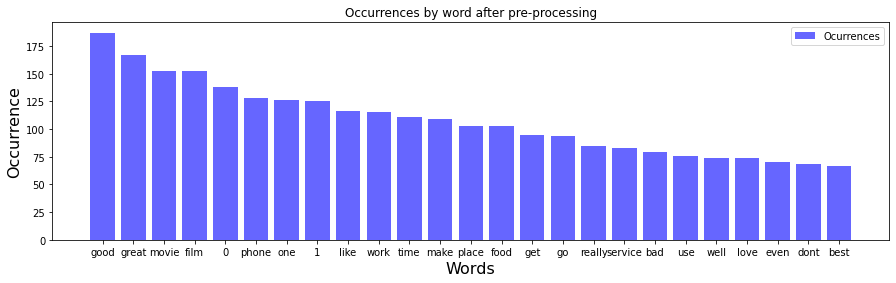

In [23]:
word_occure_cleaned = word_occurence(remove_stop_words(X_train_list_cleaned))

fig, ax = plt.subplots(figsize=(15, 4))
index = np.arange(len(word_occure_raw))
rects1 = plt.bar(x = np.arange(len(word_occure_cleaned)), 
                 height = [x[1] for x in word_occure_cleaned], 
                 width = 0.8, alpha=0.6, color='b',label='Ocurrences')

plt.xlabel('Words', size=16)
plt.ylabel('Occurrence', size=16)
plt.title('Occurrences by word after pre-processing')
plt.xticks(index + 0.8, [x[0] for x in word_occure_cleaned])
plt.xticks(index, [x[0] for x in word_occure_cleaned])
plt.legend();

- **For a better visualization, I used the "word-cloud" to represent the occurrence of different words in the data set after the cleaning. Size of the word in the word cloud image shows the freaquancy it appears in the data set.**

In [24]:
comment_words = ""
for item in remove_stop_words(X_train_list_cleaned):
    comment_words += " " + item + " "

In [25]:
wordcloud = WordCloud(width = 1500, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

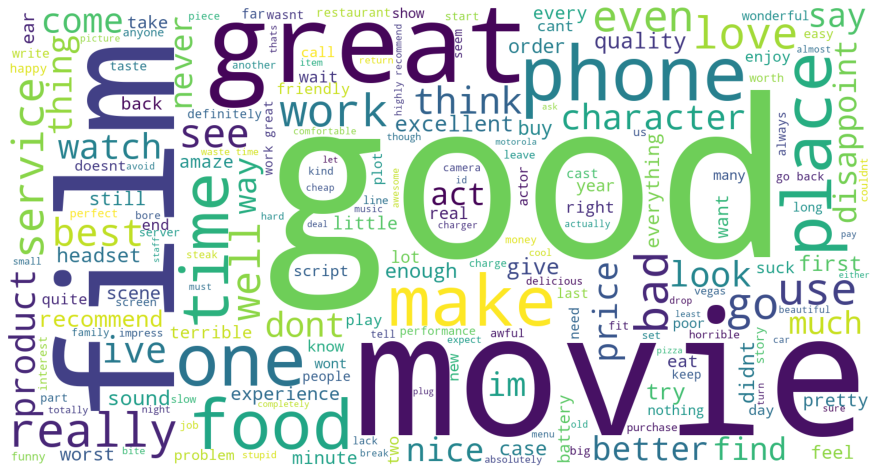

In [26]:
# plot the WordCloud image                       
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

- **Modeling Pipeline: After the pre-processing, the pipe-line for modeling was implimented. Following steps were included in the pipeline;**
1. CounterVectorizer: Convert the sentences in to vectors for the fitting. \
    (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
2. TF-IDF: Add the importance of words to vectorized-sentences as features using the frequencey of occurrences. \
    (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
3. Model initialization: Naive Bayes classifier. \
    (https://scikit-learn.org/stable/modules/naive_bayes.html)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

- **Fit to training data**

In [28]:
text_clf.fit(X_train_list_cleaned, y_train) 

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

- **Training and Testing accuracies:**

In [29]:
train_predicted = text_clf.predict(X_train_list_cleaned)
test_predicted = text_clf.predict(X_test_list_cleaned)
print ("Training Accuracy with MultinomialNB: ", round(np.mean(train_predicted == y_train)*100, 3), "%")
print ("Testing Accuracy with MultinomialNB: ", round(np.mean(test_predicted == y_test)*100, 3), "%")


Training Accuracy with MultinomialNB:  94.313 %
Testing Accuracy with MultinomialNB:  80.182 %


- **Confusion Matrix**

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1001   77]
 [  48 1072]]


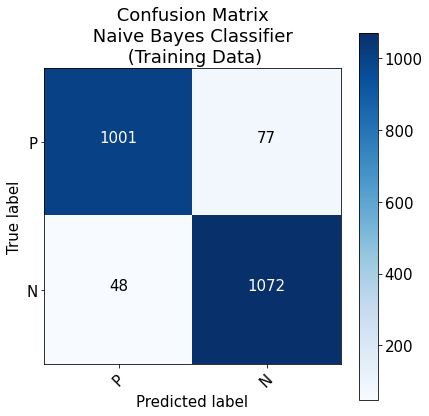

In [31]:
plt.rcParams.update({'font.size': 15})
cnf_matrix = confusion_matrix(y_train, train_predicted)
np.set_printoptions(precision=2)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes="PN",
                      title=' Confusion Matrix \n Naive Bayes Classifier \n (Training Data)')

Confusion matrix, without normalization
[[203  81]
 [ 28 238]]


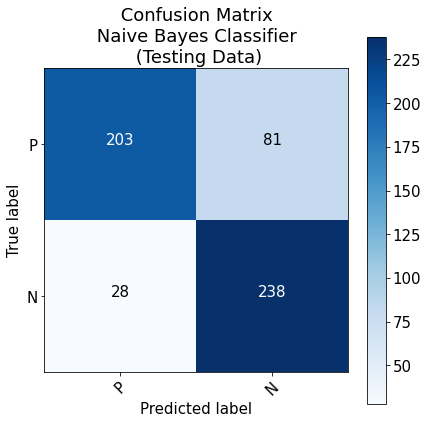

In [32]:
cnf_matrix = confusion_matrix(y_test, test_predicted)
np.set_printoptions(precision=2)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes="PN",
                      title=' Confusion Matrix \n Naive Bayes Classifier \n (Testing Data)')

- **Let's throw some reviews in and see how it performs..**

In [ ]:
def predict_label(sent_list):
    processed_sent_list = PreProcess(sent_list)
    pred_labels = text_clf.predict(processed_sent_list)
    for sent, pred in zip(sent_list, pred_labels):
        if pred == 1:
            out="GOOD"
            cl='green'
        else:
            out="BAD"
            cl='red'
        print(colored("[", 'blue'), end="")
        print(colored(sent, 'blue'), end="") 
        print(colored("]", 'blue'), end="")
        print(" is a ", end="")
        print(colored(out, cl), end="") 
        print(" review")

In [57]:
test_string = ["that product is very good", "disgusting", "I don't like that", \
               "I'm disappointed", "Very useful toolkit", "It was a mistake", \
               "I will never buy that again", "total bulshit", \
               "I'm using it everyday.", "I purchased it yersterday and returned it today!!",\
               "I'm using it for more than 5 years now"]
predict_label(test_string)    

[that product is very good] is a GOOD review
[disgusting] is a BAD review
[I don't like that] is a BAD review
[I'm disappointed] is a BAD review
[Very useful toolkit] is a GOOD review
[It was a mistake] is a BAD review
[I will never buy that again] is a BAD review
[total bulshit] is a BAD review
[I'm using it everyday.] is a GOOD review
[I purchased it yersterday and returned it today!!] is a BAD review
[I'm using it for more than 5 years now] is a GOOD review


- **Limitations and must-do improvements:**

In [69]:
predict_label(["Not working"])

[Not working] is a GOOD review


In [72]:
predict_label(["doesn't work"])

[doesn't work] is a BAD review


In [76]:
predict_label(["Not useful"])

[Not useful] is a GOOD review


In [75]:
predict_label(["isn't useful"])

[isn't useful] is a BAD review
